In [1]:
from numba import njit
import numpy as np
import os

def move_to_parent_dir():
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    os.chdir(parent_directory)
    print("Working directory:", os.getcwd())

move_to_parent_dir() 

Working directory: c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19


# Load Tapes Data

Opening UoB_Set01_2025-01-02tapes.csv
Opening UoB_Set01_2025-01-03tapes.csv
Opening UoB_Set01_2025-01-06tapes.csv
Opening UoB_Set01_2025-01-07tapes.csv
Opening UoB_Set01_2025-01-08tapes.csv
Opening UoB_Set01_2025-01-09tapes.csv
Opening UoB_Set01_2025-01-10tapes.csv
Opening UoB_Set01_2025-01-13tapes.csv
Opening UoB_Set01_2025-01-14tapes.csv
Opening UoB_Set01_2025-01-15tapes.csv
Opening UoB_Set01_2025-01-16tapes.csv
Opening UoB_Set01_2025-01-17tapes.csv
Opening UoB_Set01_2025-01-20tapes.csv
Opening UoB_Set01_2025-01-21tapes.csv
Opening UoB_Set01_2025-01-22tapes.csv
Opening UoB_Set01_2025-01-23tapes.csv
Opening UoB_Set01_2025-01-24tapes.csv
Opening UoB_Set01_2025-01-27tapes.csv
Opening UoB_Set01_2025-01-28tapes.csv
Opening UoB_Set01_2025-01-29tapes.csv
Opening UoB_Set01_2025-01-30tapes.csv
Opening UoB_Set01_2025-01-31tapes.csv
Opening UoB_Set01_2025-02-03tapes.csv
Opening UoB_Set01_2025-02-04tapes.csv
Opening UoB_Set01_2025-02-05tapes.csv
Opening UoB_Set01_2025-02-06tapes.csv
Opening UoB_

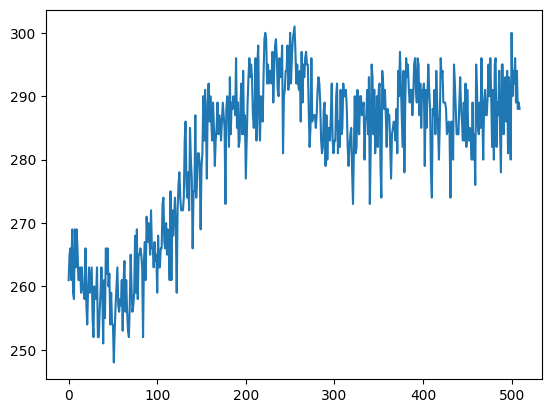

In [2]:
# get test data
import matplotlib.pyplot as plt
from tools import get_Tapes
tapes = get_Tapes(125,0)
test_data = tapes[0]
test_data = test_data["Price"].resample("1min").last().ffill().to_numpy()
plt.plot(test_data)

# Define Broker and Example Agent

In [3]:
@njit
def broker(actor, price_data: np.array, starting_cash: int):
    time_index = 0
    final_time_index = price_data.shape[0]
    num_stocks = np.zeros_like(price_data)
    cash_value = np.zeros_like(price_data)
    cash_value[0] = starting_cash

    while True:
        action = actor(price_data[:time_index], cash_value[time_index], num_stocks[time_index])

        if action == 1: # buy one stock
            if cash_value[time_index] >= price_data[time_index]:
                cash_value[time_index] = cash_value[time_index] - price_data[time_index]
                num_stocks[time_index] = num_stocks[time_index] + 1

        elif action == 2: # sell one stock
            if num_stocks[time_index] > 0:
                num_stocks[time_index] = num_stocks[time_index] - 1
                cash_value[time_index] = cash_value[time_index] + price_data[time_index]
        else: # do nothing
            pass


        time_index += 1
        if time_index >= final_time_index:
            break

        num_stocks[time_index] = num_stocks[time_index - 1]
        cash_value[time_index] = cash_value[time_index - 1]

    total_value = num_stocks * price_data + cash_value

    return num_stocks, cash_value, total_value

@njit
def random_actor(current_data, current_cash, current_stocks):
    return np.random.randint(1,3)

num_stocks, cash_value, total_value = broker(random_actor, test_data, 10000)

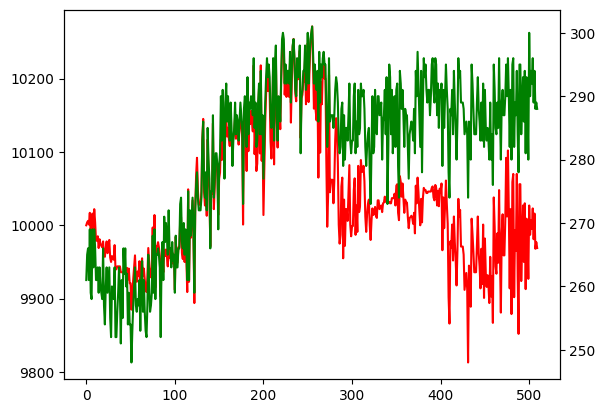

In [4]:
plt.plot(total_value, 'r')
plt.twinx()
plt.plot(test_data, 'g')
plt.show()

# Test time taken

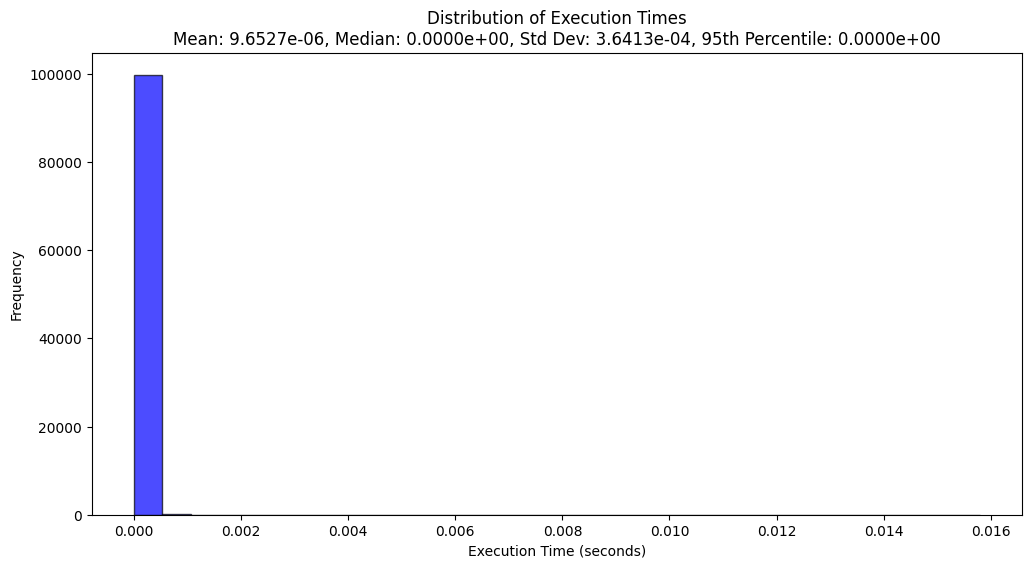

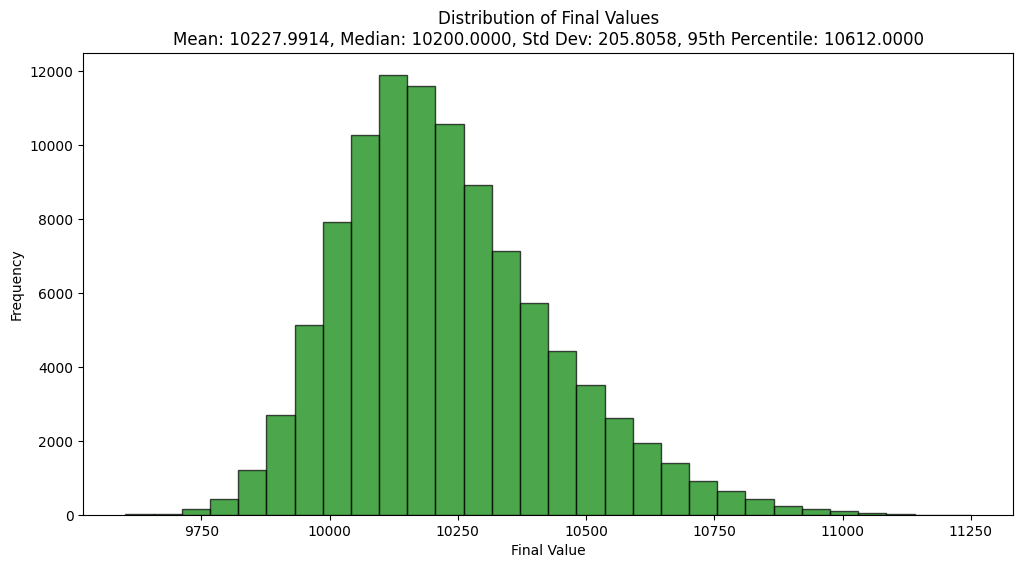

In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt

# it approximately takes 1e-5 to run one day. that is 10_000 a second

def analyse_agent(data, agent, n_runs = 100_000,):
    times = []
    final_values = []

    for i in range(n_runs):
        # Measure execution time
        start_time = time.time()
        num_stocks, cash_value, total_value = broker(agent, data, 10000)
        execution_time = time.time() - start_time
        
        # Store execution time and final value
        times.append(execution_time)
        final_values.append(total_value[-1])

    # Summary statistics
    mean_time = np.mean(times)
    median_time = np.median(times)
    std_dev_time = np.std(times)
    percentile_95_time = np.percentile(times, 95)

    mean_final_value = np.mean(final_values)
    median_final_value = np.median(final_values)
    std_dev_final_value = np.std(final_values)
    percentile_95_final_value = np.percentile(final_values, 95)

    # Plot histograms with labels and titles
    plt.figure(figsize=(12, 6))
    plt.hist(times, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Execution Time (seconds)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Execution Times\nMean: {:.4e}, Median: {:.4e}, Std Dev: {:.4e}, 95th Percentile: {:.4e}'.format(mean_time, median_time, std_dev_time, percentile_95_time))
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.hist(final_values, bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.xlabel('Final Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Final Values\nMean: {:.4f}, Median: {:.4f}, Std Dev: {:.4f}, 95th Percentile: {:.4f}'.format(mean_final_value, median_final_value, std_dev_final_value, percentile_95_final_value))
    plt.show()

analyse_agent(test_data, random_actor)

# Testing a simple agent

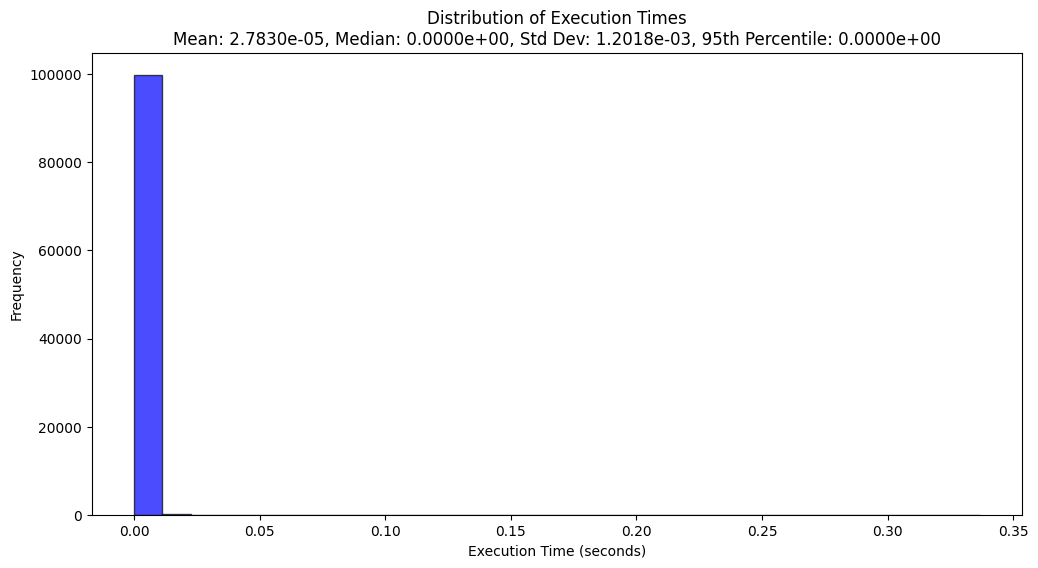

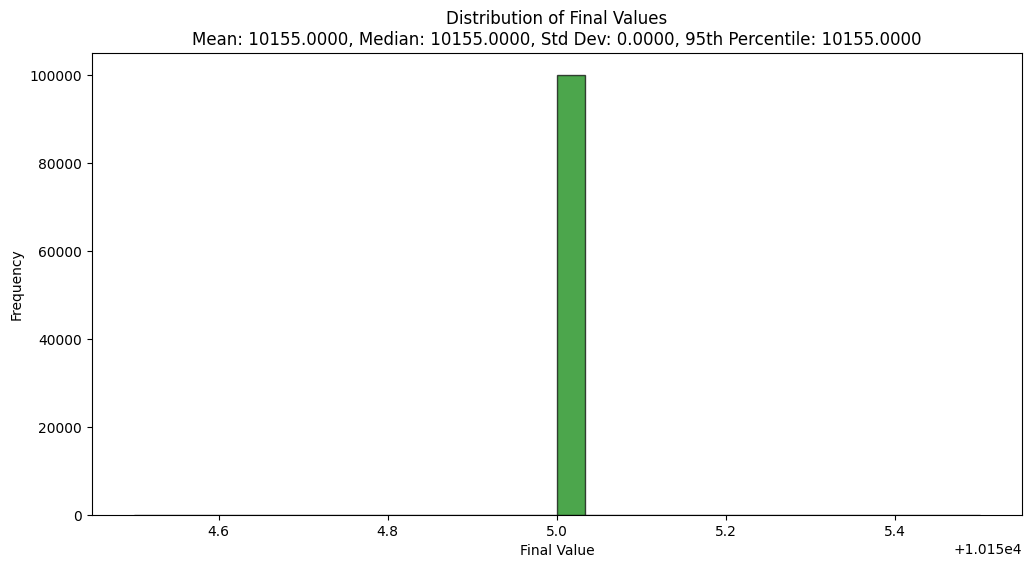

In [6]:
@njit
def agent_MA(current_data, current_cash, current_stocks):
    window = 10
    if len(current_data) == 0:
        return 0
    ma = np.mean(current_data[-window:])

    eps = 0
    if current_data[-1] > ma + eps:
        return 2
    elif current_data[-1] < ma - eps:
        return 1
    else:
        return 0

# 2.75e-5 per run
analyse_agent(test_data, agent_MA)


# Armia Test Agent (on training data)

In [21]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(test_data, order=[1,0,1])
result = arima_model.fit()
result2 = result.apply(test_data)
arima_values = result2.predict()

@njit
def arima_agent(current_data, current_cash, current_stocks):
    index = len(current_data)
    a_v = arima_values[index]
    eps = 0
    if current_data[-1] > a_v + eps:
        return 2
    elif current_data[-1] < a_v - eps:
        return 1
    else:
        return 0
    
arima_agent([0],0,0)

1

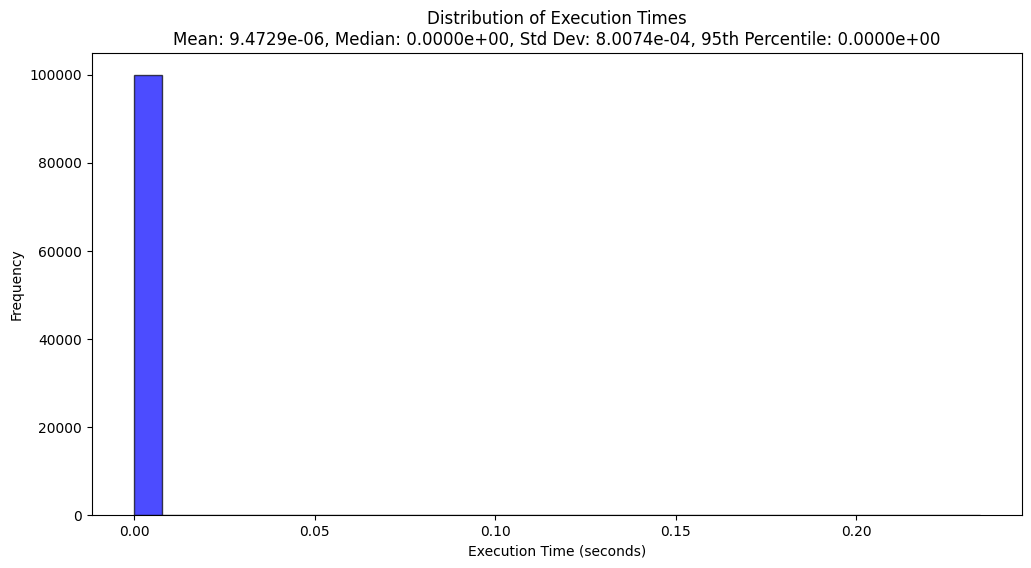

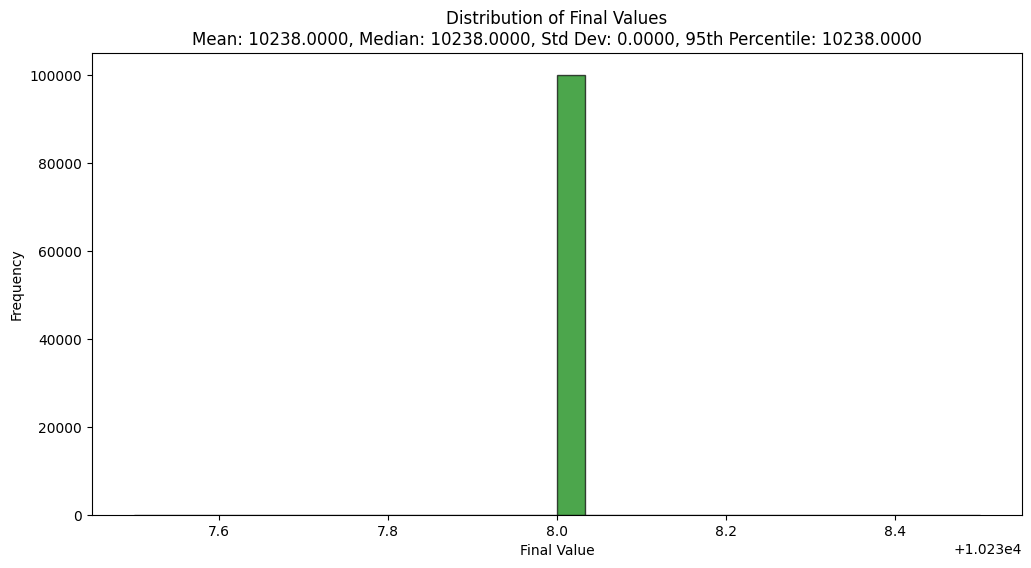

In [22]:
analyse_agent(test_data, arima_agent)

# RSI Index

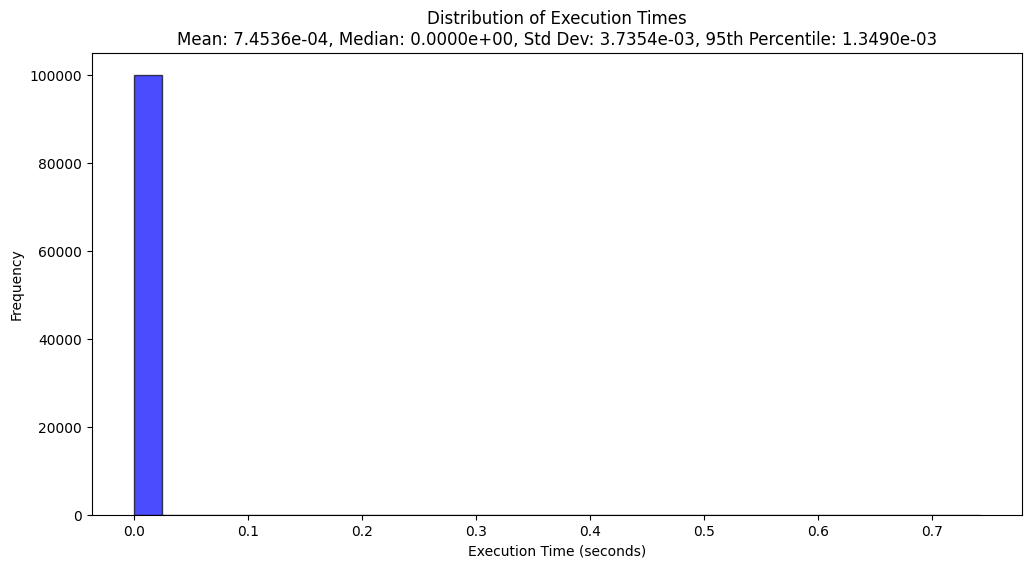

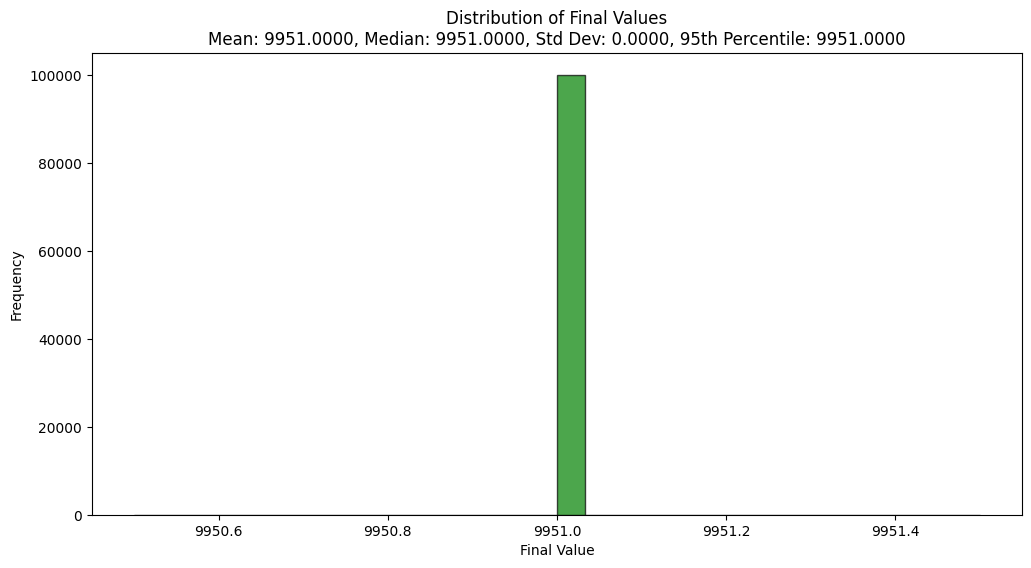

In [16]:
@njit
def agent_RSI(current_data, current_cash, current_stocks):
    if len(current_data) == 0:
        return 0
    past_data = current_data[-13:]
    past_diff = np.diff(past_data)

    gains = past_diff[past_diff > 0]
    if len(gains) > 0:
        avg_gain = np.mean(gains)
    else:
        avg_gain = 0

    losses = past_diff[past_diff < 0]
    if len(losses) > 0:
        avg_loss = np.abs(np.mean(losses))
    else:
        avg_loss = 1e-20
    rs = avg_gain / avg_loss

    rsi = 100 - (100 / (1 + (rs)))
    
    if rsi > 70:
        return 2
    elif rsi < 30:
        return 1
    else:
        return 0
# 7.5e-4 per simulation
analyse_agent(test_data, agent_RSI)

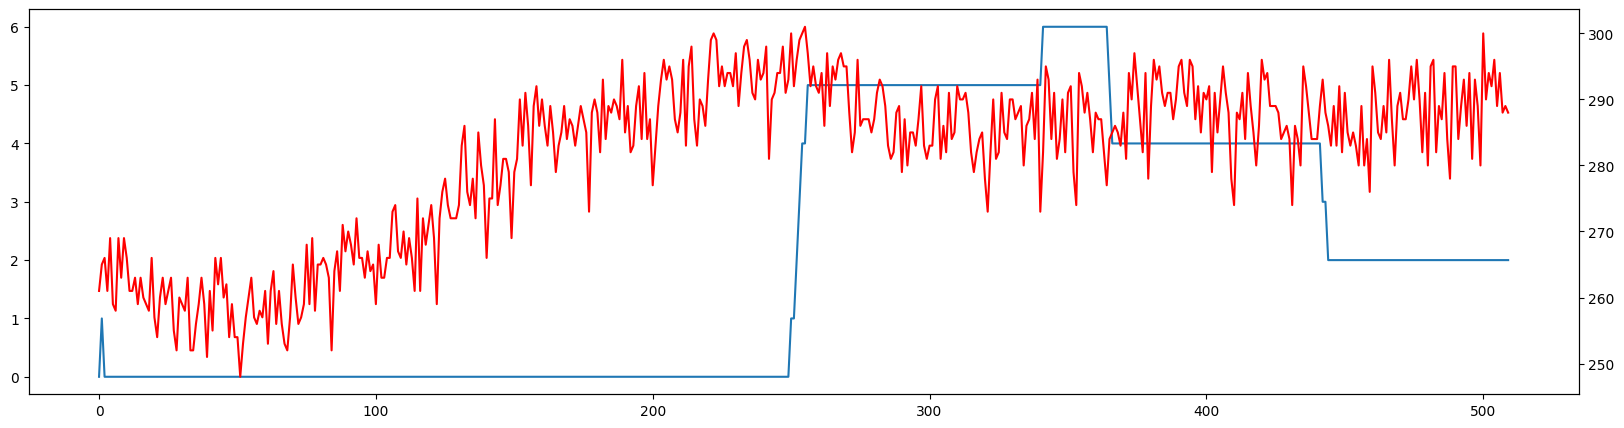

In [15]:
num_stocks, cash_value, total_value = broker(agent_RSI, test_data, 10000)

plt.figure(figsize=(20,5))
plt.plot(num_stocks)
plt.twinx()
plt.plot(test_data, 'r')

# Get Test Train Splits

In [11]:
#processed_data = np.array([t["Price"].resample("1min").last().ffill().to_numpy() for t in tapes])
#test_size = 25
#test_indicies = np.random.randint(0,125,size = test_size)
#train_data = processed_data[~test_indicies]
#test_data = processed_data[test_indicies]